**Oreum Industries Internal Project, 2024Q3**

---

# 000_Intro.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

**_What is Survival Regression?_**

We seek to create _principled_ models that provide explanatory inference and predictions of the
Survival Function $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$ of real-world events experienced by 
a population, using quantified uncertainty to support real-world decision-making.

**General project approach**

The emphasis in this project is on building a variety of models and demonstrating their usage. We strike a balance 
between building up concepts & methods (similar to Betancourt's detailed article) vs practical 
application & worked examples in a `pmyc`-based Bayesian workflow. We don't focus on specific analysis of the dataset,
nor try to infer too much. The dataset is simply a good substrate on which to learn and demonstrate
the variety of model architectures used herein.

**This series of Notebooks covers**

+ `000_Intro.ipynb`: basic orientiation and fundamental concepts
  
+ The __10x\_Exponential family__: basic exponential parametric and semi-parametric (piecewise) structure
  + `100_Exponential_Univariate.ipynb`: A Parametric Univariate Model: Constant Hazard
  + `101_Exponential_Regression.ipynb`: A Parametric Regression aka Accelerated Failure Time Model: Exponential
  + `102_Exponential_CoxPH0.ipynb`: A Semi-Parametric aka Piecewise Regression Model: CoxPH
  
+ The __20x\_AFT family__: extension of parametric models with focus on Accelerated Failure Time structure
  + `200_AFT_Weibull.ipynb`: A Parametric Regression aka AFT Model: Weibull
  + `201_AFT_Gompertz.ipynb`: A Parametric Regression aka AFT Model: Gompertz
  + `202_AFT_GompertzAlt.ipynb`: A Parametric Regression aka AFT Model: Gompertz Alternative Parameterization

+ The __30x\_Piecewise family__: extension of semi-parametric models with focus on Hierarchical & Ordinal structure
  + `300_Piecewise_CoxPH1.ipynb`: Extending CoxPH: Hierarchical Baseline Hazard
  + `301_Piecewise_CoxPH2.ipynb`: Extending CoxPH: Ordinal Hierarchical Baseline Hazard  
  + `302_Piecewise_CoxPH3.ipynb`: Extending CoxPH: Ordinal Hierarchical Baseline Hazard & Coeffs


**Some references**

This also references / remixes / extends a handful published guides & notes including:

+ [WWS507 Chap7, online here](https://grodri.github.io/glms/notes/c7.pdf) and 
  also saved to pdf in this project repo at 
  `../assets/pdf/wws507_pop507_generalized_linear_statistical_models_c7.pdf`
+ [Michael Betancourt's article](https://betanalpha.github.io/assets/case_studies/survival_modeling.html) on Bayesian survival model fundamentals
+ [Austin Rochfort's gist](https://gist.github.com/AustinRochford/4c6b07e51a2247d678d6) and [updated gist](https://gist.github.com/AustinRochford/461c74db80833fdf4287ba91ee136b8f) both on CoxPH, and [gist](https://gist.github.com/AustinRochford/4b8a163b66a11cdcbc430797b9b664fe#file-bayes_param_survival_pymc3-ipynb) on AFT
+ [Chris Fonnesbeck's gist](https://gist.github.com/fonnesbeck/04e6e569e207fc045a22)
+ [The `pymc-examples` docs](https://www.pymc.io/projects/examples/en/latest/survival_analysis/frailty_models.html)
+ [The `lifelines` api docs](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis)
+ [Monica Alexander's workflow example](https://www.monicaalexander.com/posts/2020-28-02-bayes_viz/)
+ This is a comprehensive update of `appliedai_bayesiansurvivaldemo/01_BayesianSurvivalModelling` written in 2016

**In this Notebook**

We dive straight into **Basic Orientation** and **Fundamental General Abstrations** with a simple real-world 
observational censored dataset, and then go on to demonstrate the theory and usage of an increasing sophistication of models.


## Contents

+ [Setup](#Setup)

+ [Preamble](Preamble)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Basic Orientation: Non-Parametric Estimators](#1.-Basic-Orientation:-Non-Parametric-Estimators)

+ [2. Fundamental General Abstrations](#2.-Fundamental-General-Abstrations)

---


# Setup

## Imports

In [1]:
import sys
from pathlib import Path

import lifelines as sa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pyprojroot.here import here
from scipy import stats

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

from oreum_core import curate, eda

from engine import logger

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('000_Intro', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
LOAD_FROM_CSV = True
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))
staticimgio = eda.FigureIO(here(Path('assets', 'img')).resolve(strict=True))

---

---

# Preamble

## We gain massive advantage by using a Bayesian Framework

We specifically use [**Bayesian Inference**](https://www.pymc.io/blog/chris_F_pydata2022.html)
rather than Frequentist max-likelihood for many reasons:

| Desirable Trait | Bayesian Inference | Frequentist Max-Likelihood |
| --- | --- | ---|
| **_Principled_ model structure represents hypothesis about the data-generating process** | **Very strong** <br/> Can build bespoke arbitrary and hierarchical structures of parameters to map to the real-world data-generating process. | **Weak** <br/> Can only state structure under strict limited assumptions of model statistical validity. |
| **Model parameters and their initial values represent domain expert knowledge** | **Very strong** <br/>Marginal prior distributions represent real-world probability of parameter values before any data is seen. | **Very weak** <br/> No concept of priors. Lack of joint probability distribution can lead to discontinuities in parameter values. |
| **Robust parameter fitting process** | **Strong** <br/> Estimate full joint posterior probability mass distribution for parameters - more stable and representative of the expectation fr the parameter values. Sampling can be a computationally expensive process. | **Weak** <br/> Estimate single-point max-aposterioi-likelihood (density) of  parameters - this can be far ouside the probability mass and so is prone to overfitting and only correct in the limit of infinite data. But optimization method can be computationally cheap. |
| **Robust model evaluation process** | **Strong** <br/>Use entire dataset, evaluate via Leave-One-Out Cross Validation (best theoretically possible). | **Weak** <br/> Cross-validation rarely seen in practice, even if used, rarely better than 5-fold CV. Simplistic method can be computationally cheap. |
| **Fitted parameters have meaningful summary statistics for inference** | **Very strong** <br/>Full marginal probability distributions can be interpreted exactly as probabilities. | **Weak** <br/>Point estimates only have meaningful summary statistics under strict limited assumptions of model statistical validity. |

... continued

| Desirable Trait | Bayesian Inference | Frequentist Max-Likelihood |
| --- | --- | ---|
| **Predictions made with quantified variance** | **Very strong** <br/>Predictions made using full posterior probability distributions, so predictions have full empirical probability distributions. | **Weak** <br/>Predictions using point estimates can be bootstrapped, but predictions only have interpretation under strict limited assumptions of model validity. |
| **Handle imbalanced, high cardinality & hierarchical factor features** | **Very strong** <br/>Can introduce partial-pooling to automatically balance factors through hierarchical priors. | **Weak** <br/>Difficult to introduce partial-pooling (aka mixed random effects) without affecting strict limited assumptions of model validity. |
| **Handle skewed / multimodal / extreme value target variable** | **Very strong** <br/>Represent the model likelihood as any arbitrary probability distribution, including mixture (compound) functions e.g. a zero-inflated Weibull. | **Weak** <br/>Represent model likelihood with a usually very limited set of distributions. Very difficult to create mixture compound functions. |
| **Handle small datasets** | **Very strong** <br/>Bayesian concept assumes that there is a probable range of values for each parameter, and that we evidence our prior on any amount of data (even very small counts). | **Very weak** <br/>Frequentist concept assumes that there is a single true value for each parameter and that we only discover that value in the limit (of infinite observations). |
| **Automatically impute missing data** | **Very strong** <br/>Establish a prior for each datapoint, evidence on the available data within the context of the model, to automatically impute missing values. | **Very weak** <br/>No inherent method. Usually impute as a pre-processing step with weak non-modelled methods. |

---

---

# 0. Load Dataset

For this Intro Notebook we'll use a simple dataset with censoring: the 
[`mastectomy`](https://vincentarelbundock.github.io/Rdatasets/doc/HSAUR/mastectomy.html) dataset from the 
[`HSAUR`](https://cran.r-project.org/web/packages/HSAUR/index.html) R package via `statsmodels`

Per the documentation this dataset represents:

>Survival times in months after mastectomy of women with breast cancer. The cancers are classified as having metastasized or not based on a histochemical marker.

* `time` is the number of months since mastectomy,
* `event` indicates whether the woman died at the corresponding `time` (if `True`) or the observation was [censored](https://en.wikipedia.org/wiki/Survival_analysis#:~:text=Censoring%20%2F%20Censored%20observation%3A%20Censoring%20occurs,after%20the%20time%20of%20censoring.) (if `False`).  In the context of [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis), censoring means that the woman survived past the corresponding time, but that her death was not observed.  Censoring (and its counterpart [truncation](https://www.usu.edu/math/jrstevens/biostat/projects2013/pres_LeftTruncation.pdf)) represents a fundamental challenge in survival analysis
* `metastized` indicates whether the woman's cancer had [metastasized](https://en.wikipedia.org/wiki/Metastasis)

In [5]:
if LOAD_FROM_CSV:
    dfr = csvio.read(fn='mastectomy', index_col='rowid')
else:
    dfr = sm.datasets.get_rdataset(dataname='mastectomy', package='HSAUR', cache=True).data
    _ = csvio.write(df=dfr, fn='mastectomy')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Basic Orientation: Non-Parametric Estimators

## 1.1 Example Frequency Tables & Lifetime Plots

### 1.1.1 Table: Death event

In [7]:
def freq_prop_table(df, ft):
    counts = df.groupby(ft).size()
    return pd.DataFrame({'freq': counts, 'prop': counts / len(df)})


freq_prop_table(df, 'death')

,freq,prop
death,,
False,18,0.409091
True,26,0.590909


**Observe:**

+ 26 obs ($59\%$) are observed death events within the observation period
+ 18 obs ($41\%$) are right-censored, see Section 1.2 for plots and discussion

### 1.1.2 Death grouped by `met`

In [8]:
piv = df.pivot_table(values='duration', index='met', columns='death', aggfunc='count', margins=True)
piv

death,False,True,All
met,,,
False,7,5,12
True,11,21,32
All,18,26,44


**Observe:**
+ Deaths within the metastized group are `21 / 32 = 65.6%`
+ Deaths within the non-metastized group are `5 / 12 = 41.7%`

### 1.1.3 Chisquare test of proportions (aka prop.test aka ztest)

In [9]:
chi2, pval, _ = sm.stats.proportions_chisquare(piv.iloc[:-1, 1], piv.iloc[:-1, -1])
print(f'chi2: {chi2:.2f}\npval: {pval:.2f}')

chi2: 2.07
pval: 0.15


**Observe**
+ The correlation of `met` and `death` appears unlikely to be pure chance

### 1.1.4 Plot individual lifetimes: `duration` x `death` (x `met`)

For each patient:

+ Duration of observation
+ Metastization
+ Death event (if observed, allowing for censoring)

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


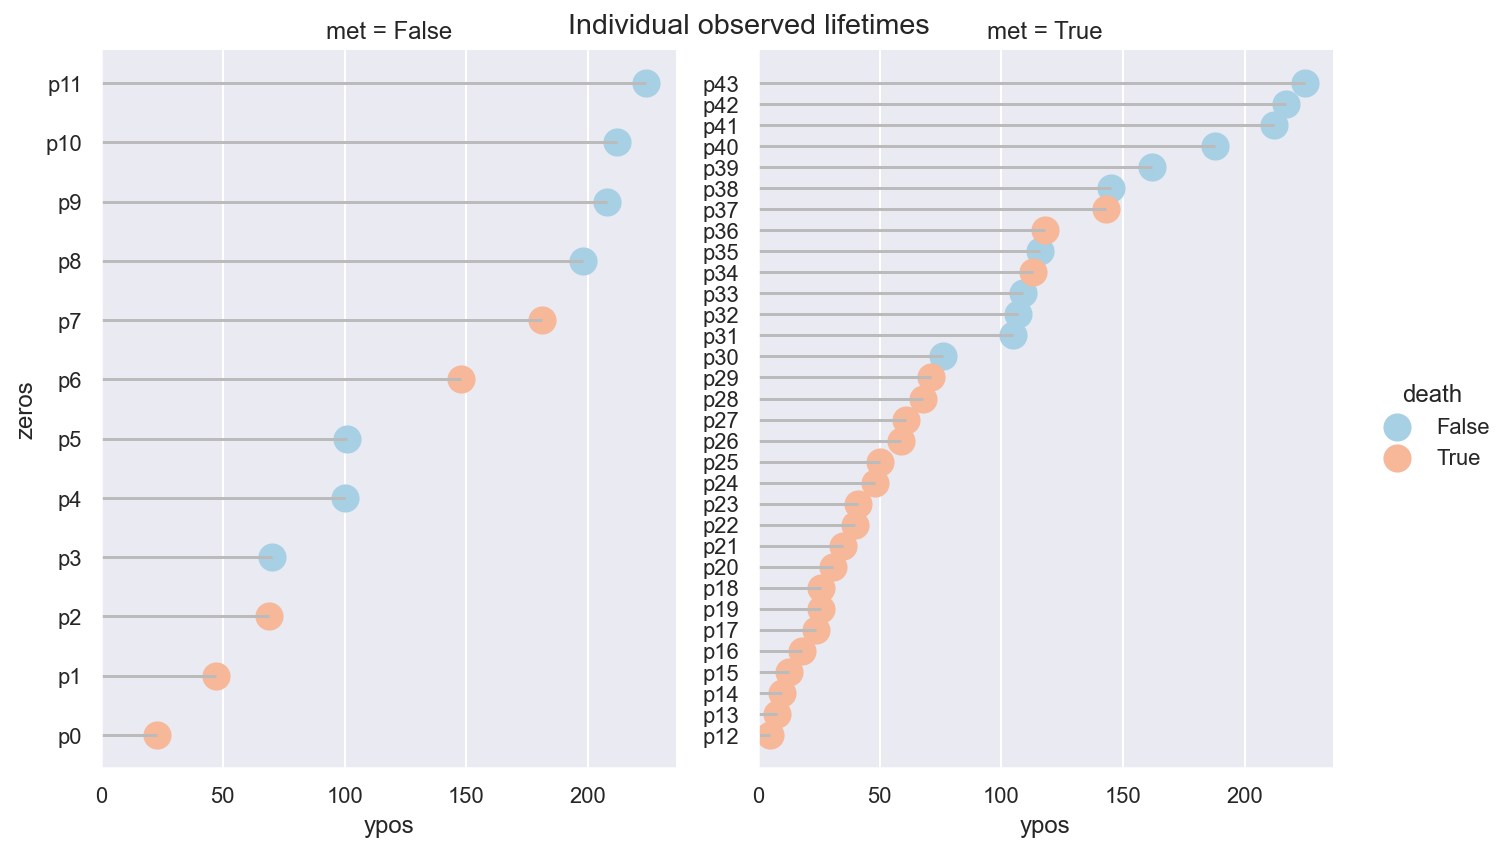

In [10]:
dfp = df.sort_values(['met', 'duration', 'death'], ascending=[1, 0, 1]).reset_index()
# dfp = df.sort_values(['met','duration','death']).reset_index()
dfp['ypos'] = dfp['pid'].apply(lambda x: (11 - int(x.strip('p')) if int(x.strip('p')) < 12 else 43 - int(x.strip('p'))))  # hack
dfp['color'] = dfp.apply(lambda r: sns.color_palette('RdBu_r', 2).as_hex()[r['death']], axis=1)
dfp['zeros'] = np.zeros(len(dfp))

g = sns.FacetGrid(col='met', data=dfp, height=6, aspect=0.8, sharey=False)
_ = g.map(sns.pointplot, 'duration', 'pid', 'death', palette='RdBu_r', join=False, orient='h', scale=1.6).add_legend(title='death')
_ = g.map(plt.hlines, 'ypos', 'zeros', 'duration', color='#bbbbbb')
_ = g.axes.flat[0].set_xlim(left=0)
_ = g.fig.suptitle('Individual observed lifetimes')

**Observe:**

+ Again we see a plausible correlation between `death` and `met`, to be 
  investigated properly via a range of models
+ Again we see right-censoring, where patients have not experienced the death event
  during the observation period

### 1.1.5 Empirical Event Density

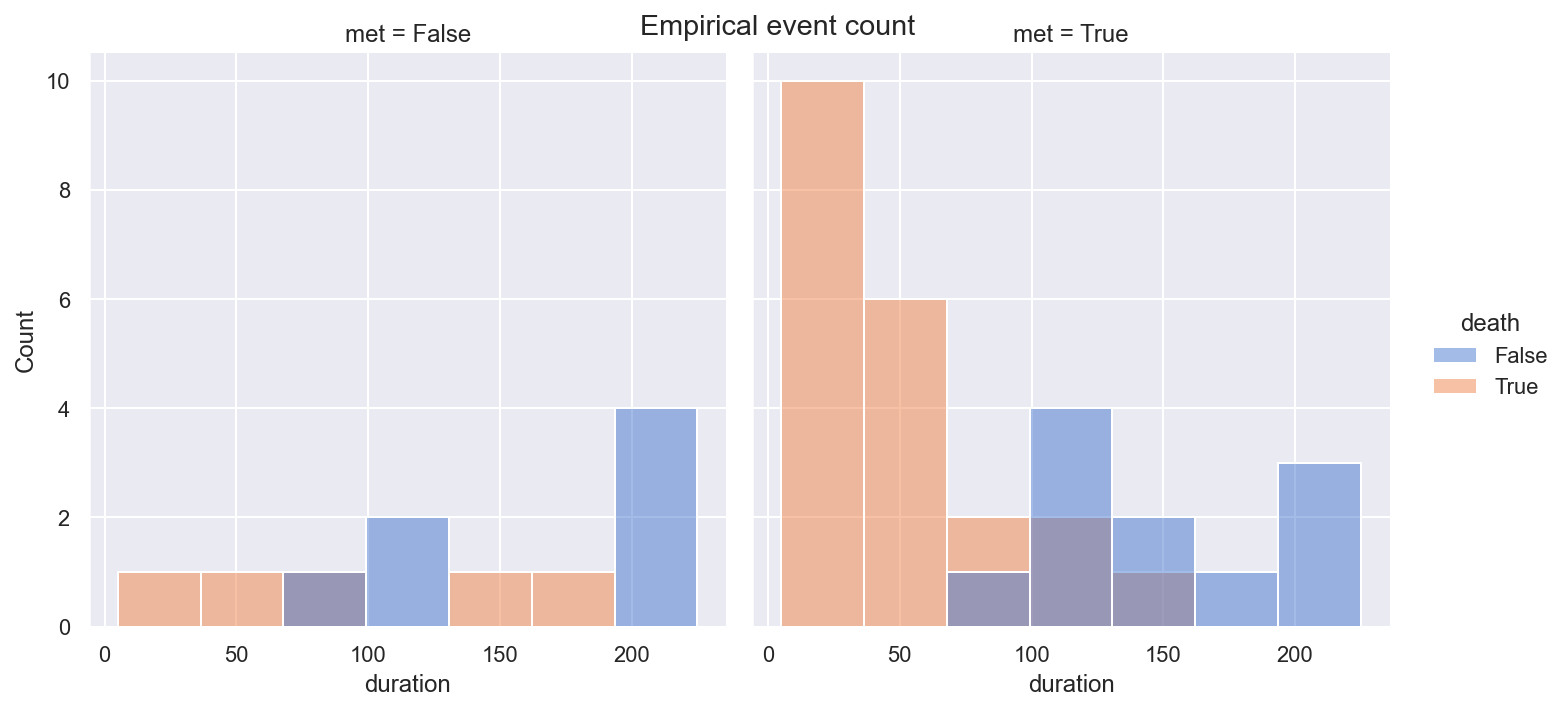

In [11]:
g = sns.displot(x='duration', hue='death', data=df, col='met', kind='hist')
_ = g.fig.suptitle('Empirical event count')

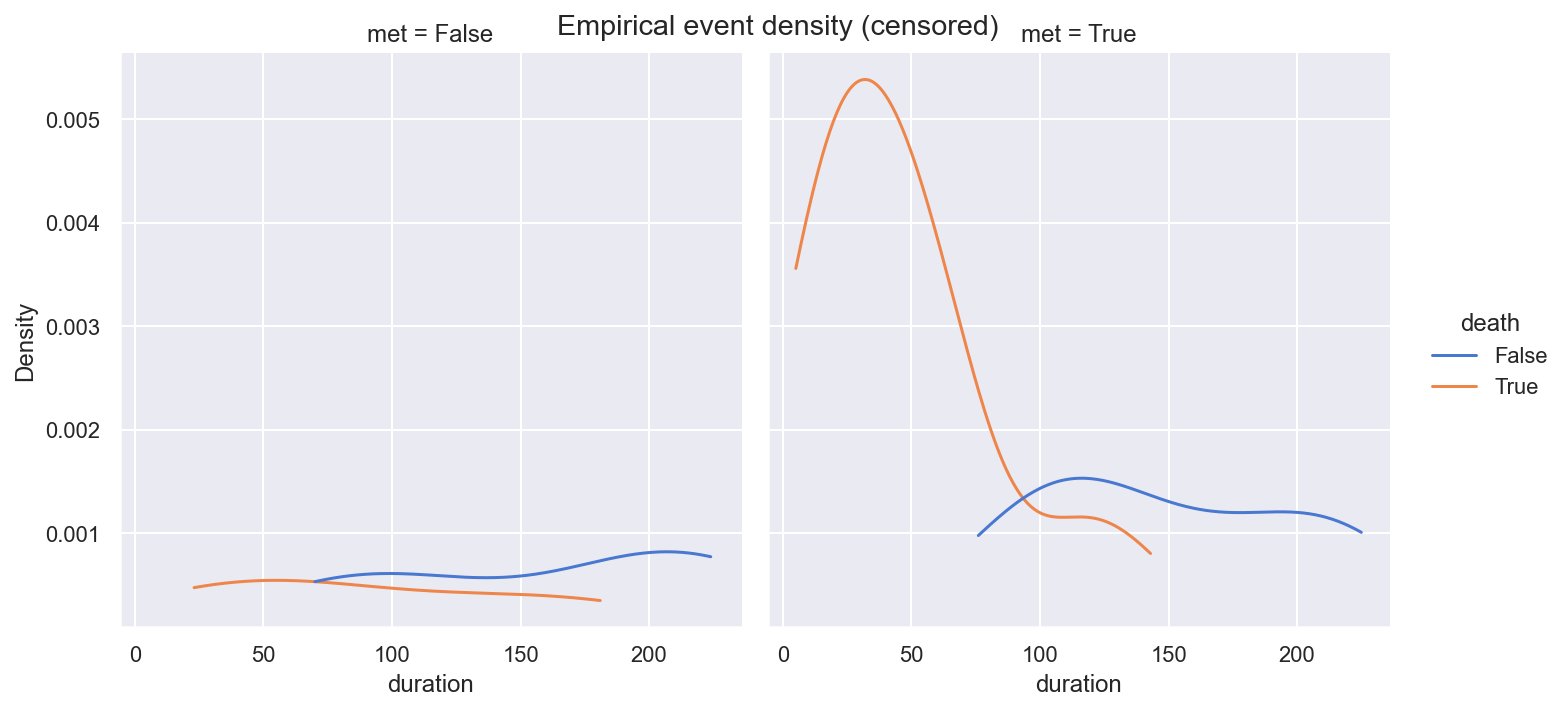

In [12]:
g = sns.displot(x='duration', hue='death', data=df, col='met', kind='kde', cut=0)
_ = g.fig.suptitle('Empirical event density (censored)')

---

## 1.2 The Kaplan Meier Estimator (empirical Survival function)

We can manually calculate a Kaplan Meier survival curve on our censored dataset
to motivate further understanding.

This empirical calcluation (not really a model per-se) is a univariate 
max-likelihood estimate of the survival function $\hat S(t)$

$$
\begin{aligned}
\hat{S}(t) = \prod\limits_{t_{i} < t} \frac{n_{i} - d_{i}}{n_{i}}
\end{aligned}
$$

where:

+ $d$ is the count of 'death' events
+ $n$ is the count of individuals at risk at timestep $i$

The cumulative product gives us a non-increasing curve where we can read off, 
at any timestep during the study, the estimated probability of survival from 
the start to that timestep. We can also compute the estimated survival time or 
median survival time (half-life) as shown above.


##### Calc manually

In [13]:
# TODO return to this to clean it up
dfg = (df.reset_index().groupby(['duration', 'death']).agg(nobs=pd.NamedAgg(column='pid', aggfunc='count'))\
        .unstack('death').droplevel(0, axis=1).rename(columns={0: 'censored_csum', 1: 'died_csum'})\
        .cumsum(axis=0).fillna(method='ffill').fillna(0))
dfg.columns.name = None
dfg['survival'] = (len(df) - dfg['died_csum']) / len(df)
dfo = pd.DataFrame.from_dict([0, 0, 1]).T
dfo.columns = dfg.columns
dfg = pd.concat((dfo, dfg), axis=0, ignore_index=False)
dfp = dfg.reindex(np.arange(dfg.index.max() + 1)).fillna(method='ffill').reset_index().rename(columns={'index': 'duration'})
eda.display_ht(dfp)

,duration,censored_csum,died_csum,survival
0,0,0.0,0.0,1.00
1,1,0.0,0.0,1.00
2,2,0.0,0.0,1.00
223,223,16.0,26.0,0.41
224,224,17.0,26.0,0.41
225,225,18.0,26.0,0.41


'Shape: (226, 4), Memsize 0.0 MB'

Calc using `lifelines.KaplanMeierFitter.survival_function_`

In [14]:
km = sa.KaplanMeierFitter(alpha=0.05)
km.fit(durations=df['duration'], event_observed=df['death'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 44 total observations, 18 right-censored observations>

In [15]:
eda.display_ht(km.event_table)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,44,44
5.0,1,1,0,0,44
8.0,1,1,0,0,43
217.0,1,0,1,0,3
224.0,1,0,1,0,2
225.0,1,0,1,0,1


'Shape: (43, 5), Memsize 0.0 MB'

### 1.2.1 Plot Survival function

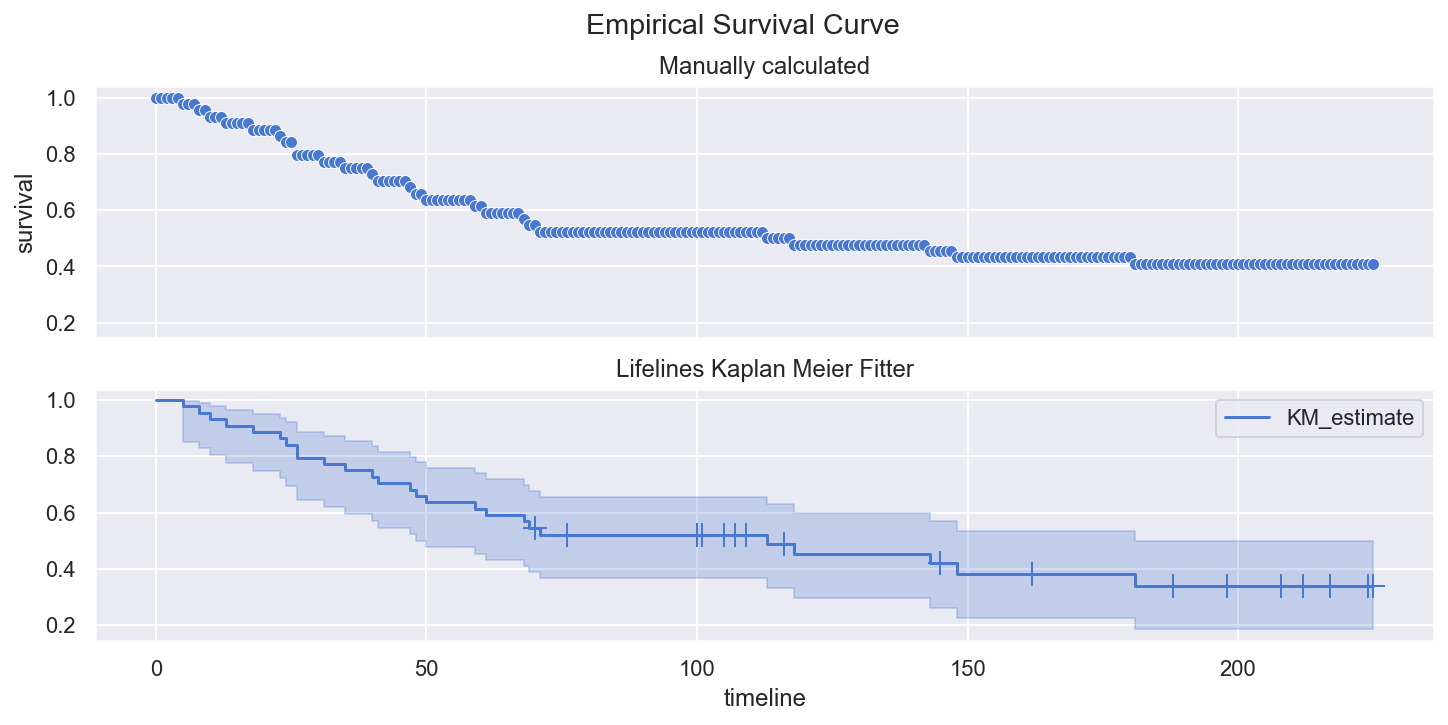

In [16]:
f, axs = plt.subplots(2, 1, figsize=(12, 5), sharey=True, sharex=True)
ax0 = sns.scatterplot(x='duration', y='survival', data=dfp, ax=axs[0])  # , color='C1')
ax1 = km.plot_survival_function(ax=axs[1], show_censors=True)
_ = ax0.set_title('Manually calculated')
_ = ax1.set_title('Lifelines Kaplan Meier Fitter')
_ = f.suptitle('Empirical Survival Curve')

**Observe:**

+ Looks reasonable
+ Same results, though `lifelines` much simpler to use than manual calculations
+ Note we're showing CI on KM fit but KM is deterministic, for details see https://myweb.uiowa.edu/pbreheny/7210/f15/notes/9-10.pdf, https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf

### 1.2.2 Calc median and mean survival times

NOTE:

+ Median is simply where the survival function crosses 50% (we can't call this "half-life" since KM is non-parametric)
+ Mean is the area under the survival curve, which can be infinite in the case of censoring, so we use a non-parametric approach

In [17]:
med = km.median_survival_time_
mn = np.trapz(y=km.survival_function_.values.flatten(), x=km.survival_function_.index)
print(f'med: {med:.1f}\nmean: {mn:.1f}')

med: 113.0
mean: 118.2


**Observe:**

+ Median and mean quite close (for this overall, non-stratified dataset)
+ More stable to take the $med \sim 113$ days, but more transferable to take the $mean \sim 118$ days
+ Again we can't call this "half-life" since KM is non-parametric


### 1.2.3 Kaplan Meier Survival Curve grouped by `met`

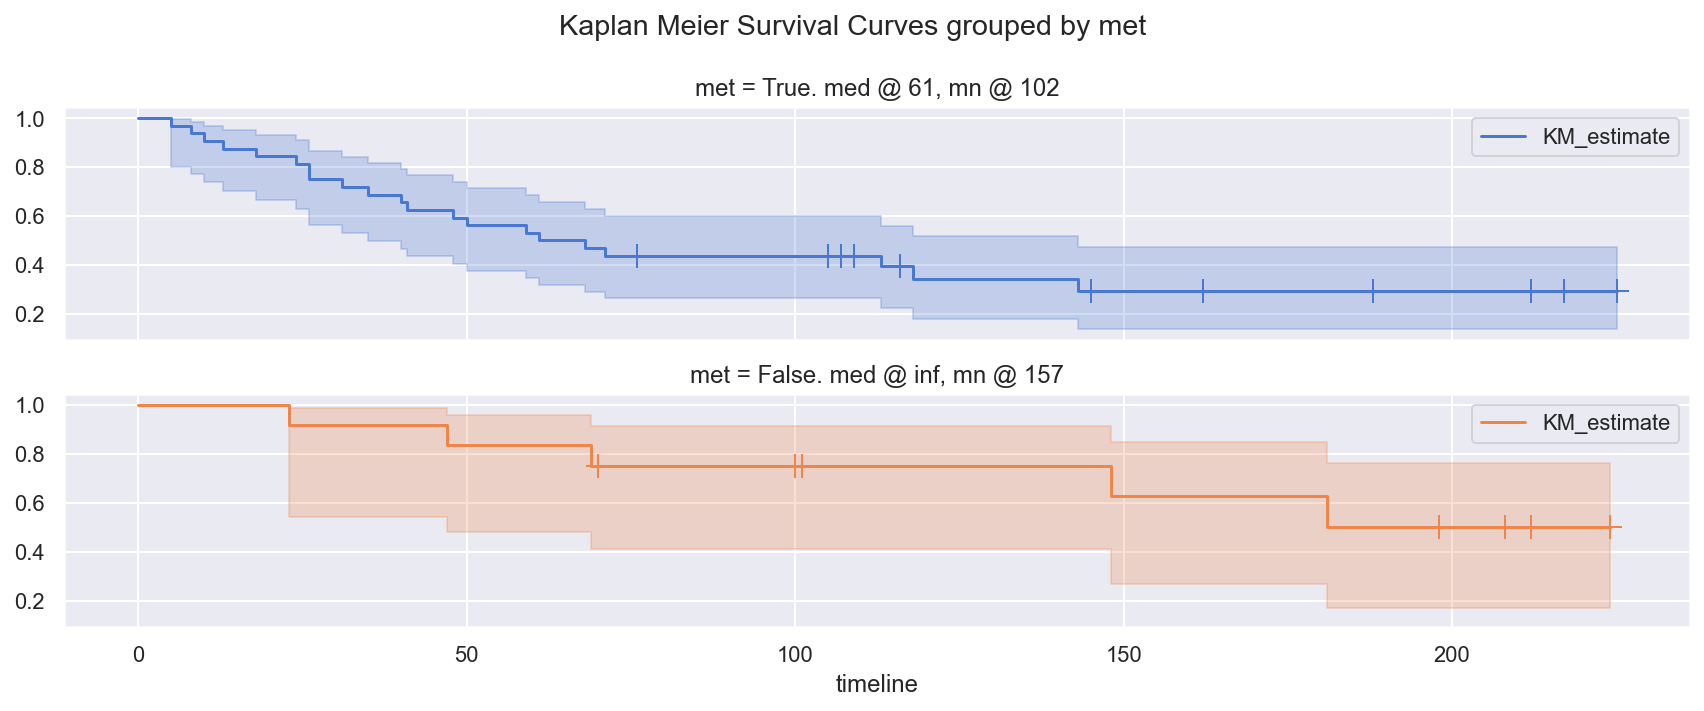

In [18]:
def get_km(g):
    """Convenience get and fit km per group"""
    km = sa.KaplanMeierFitter(alpha=0.05)
    km.fit(durations=g['duration'], event_observed=g['death'])
    return km


kmf = df.groupby('met').apply(get_km, include_groups=False)
t_med_km = kmf[True].median_survival_time_
t_mn_km = np.trapz(y=kmf[True].survival_function_.values.flatten(),
                   x=kmf[True].survival_function_.index)
f_med_km = kmf[False].median_survival_time_
f_mn_km = np.trapz(y=kmf[False].survival_function_.values.flatten(),
                   x=kmf[False].survival_function_.index)

f, axs = plt.subplots(2, 1, figsize=(12, 5), sharey=True, sharex=True)
ax0 = kmf[True].plot_survival_function(ax=axs[0], show_censors=True)
ax1 = kmf[False].plot_survival_function(ax=axs[1], show_censors=True, color='C1')
_ = ax0.set_title(f'met = True. med @ {t_med_km:.0f}' + f', mn @ {t_mn_km:.0f}')
_ = ax1.set_title(f'met = False. med @ {f_med_km:.0f}' + f', mn @ {f_mn_km:.0f}')
_ = f.suptitle('Kaplan Meier Survival Curves grouped by met')
_ = f.tight_layout()

**Observe:**

+ Larger rate of decay (shorter survival) for `met=True` (which we saw in plot 1.2.1 above)
+ For `met=True` 
  + Median survival @ $61$
  + Mean (expected) survival @ $102$ very different, due to high variance (low counts) in the small data
+ For `met=False` 
  + Median survival not observed, a weakeness in the approach
  + Mean (expected) survival @ $157$ again with high variance (low counts) in the small data


## 1.3 The Nelson Aalen Estimator (empirical Cumulative Hazard function)

Given the fundamenal abstractions noted above, we can consider a close 
alternative estimator to the Kaplan-Meier method: the **Nelson-Aalen model**.
This is also univariate, and estimates the **cumulative hazard function** 
$\Lambda(t) = -log S(t)$, and is more stable since it has a summation form:

$$
\begin{aligned}
\hat \Lambda(t) = \sum\limits_{t_{i}\leq t} \frac{d_{i}}{n_{i}}
\end{aligned}
$$

where again:

+ $d$ is the count of 'death' events
+ $n$ is the count of individuals at risk at timestep $i$

NOTE we will use our real-world censored dataset again


In [19]:
na = sa.NelsonAalenFitter(alpha=0.05, nelson_aalen_smoothing=False)
na.fit(durations=df['duration'], event_observed=df['death'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 44 total observations, 18 right-censored observations>

#### Now we can plot the hazard function across time

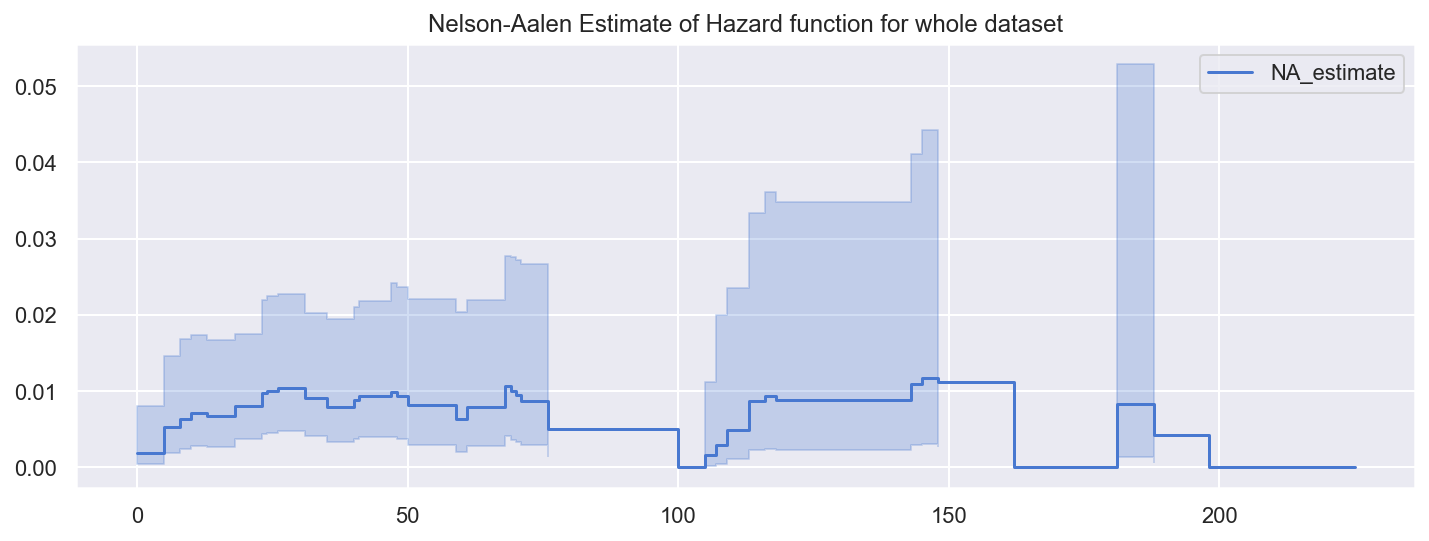

In [20]:
ax = na.plot_hazard(bandwidth=10)
_ = ax.set_title('Nelson-Aalen Estimate of Hazard function for whole dataset')

**Observe:**

+ The hazard function $\lambda(t)$ is instantaneous, non-monotonic, and bounded $[0, \infty)$ so it's a convenient measure to estimate
+ The cumulative hazard function $\Lambda(t)$ is more stable

> lets compare with the KM estimator output on the subgrouped data

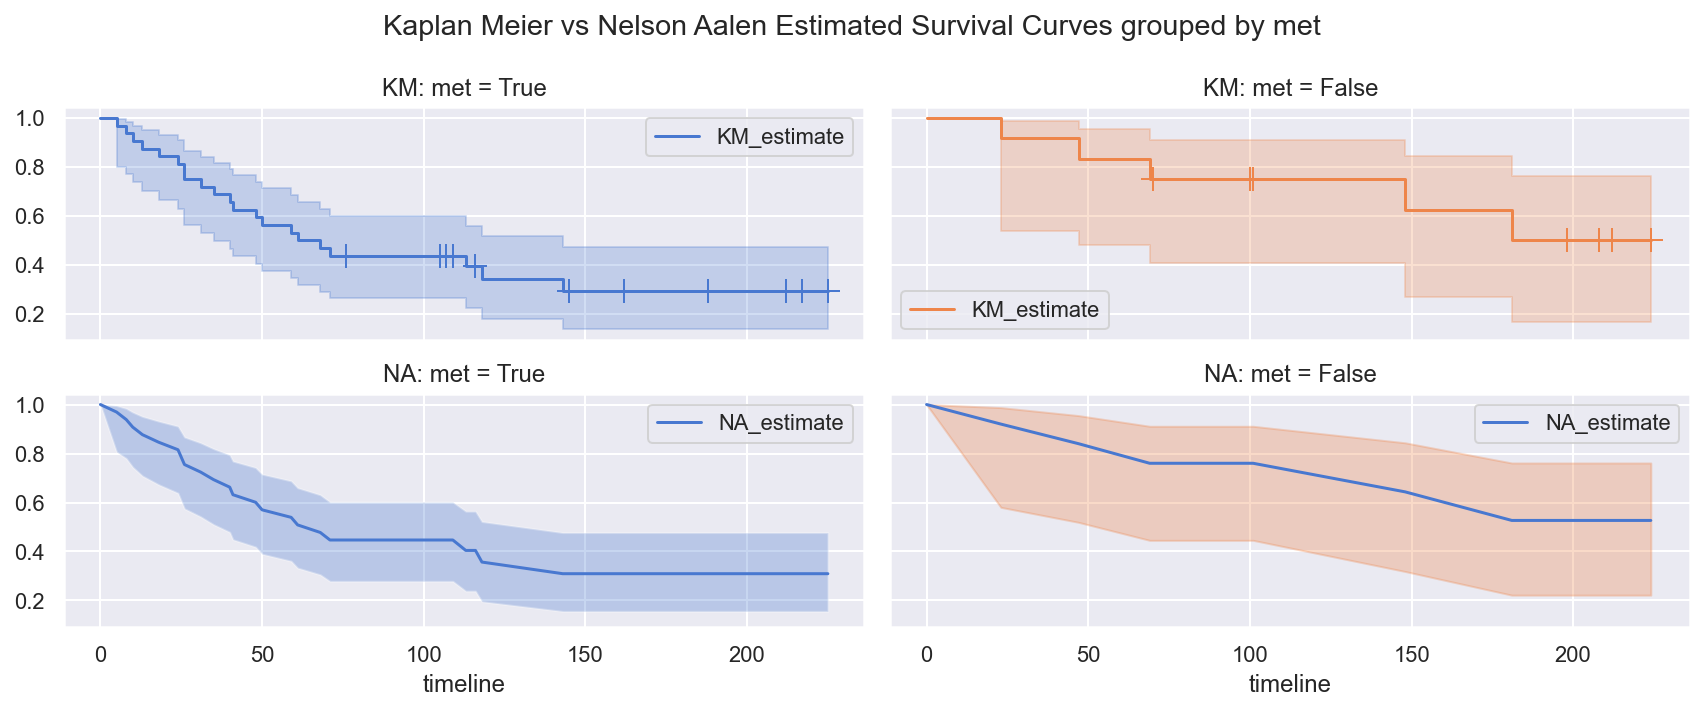

In [21]:
def get_na(g):
    """Convenice get and fit na per group"""
    na = sa.NelsonAalenFitter(alpha=0.05, nelson_aalen_smoothing=False)
    na.fit(durations=g['duration'], event_observed=g['death'])
    return na


naf = df.groupby('met').apply(get_na, include_groups=False)

f, axs = plt.subplots(2, 2, figsize=(12, 5), sharey=True, sharex=True)
ax00 = kmf[True].plot_survival_function(ax=axs[0][0], show_censors=True)
ax01 = kmf[False].plot_survival_function(ax=axs[0][1], show_censors=True, color='C1')
_ = ax00.set_title(f'KM: met = True')
_ = ax01.set_title(f'KM: met = False')

Lam = naf[True].cumulative_hazard_
Lam_ci = naf[True].confidence_interval_
s = np.exp(-Lam)
s_ci = np.exp(-Lam_ci)
ax10 = sns.lineplot(s, ax=axs[1][0])
_ = ax10.fill_between(x=s_ci.index, y1=s_ci.iloc[:, 0], y2=s_ci.iloc[:, 1], alpha=0.3)

Lam = naf[False].cumulative_hazard_
Lam_ci = naf[False].confidence_interval_
s = np.exp(-Lam)
s_ci = np.exp(-Lam_ci)
ax11 = sns.lineplot(s, ax=axs[1][1], color='C1')
_ = ax11.fill_between(x=s_ci.index, y1=s_ci.iloc[:, 0], y2=s_ci.iloc[:, 1], alpha=0.3, color='C1')

_ = ax10.set_title(f'NA: met = True')
_ = ax11.set_title(f'NA: met = False')
_ = f.suptitle('Kaplan Meier vs Nelson Aalen Estimated Survival Curves grouped by met')
_ = f.tight_layout()

**Observe:**

+ Very similar-looking survival curve estimates, and confidence intervals too
+ NA gives interpolation between points
+ NA still has most of the issues of KM: non-parametric summary of data, rather than a principled model estimator, but the hazard function can be a useful measure.

---

---

# 2. Fundamental General Abstrations

So far, we've only considered an empirical survival function, which by 
definition occupies the range $[0, 1]$ and can only monotonically decrease.

We could make a further assumption that the event (death) _must_ happen within
our observation period, i.e. the observation period is infinte and there is no 
censoring. This is an unrealistic assumption in practice, and we will quickly 
return to considering censored data, but allows further derivations.

## 2.1 The Core Functions

### 2.1.1 Survival function $S(t)$, cumulative hazard function $\Lambda(t)$, hazard function $\lambda(t)$

Due to these properties, we can alteratively state the **survival function** $S(t)$
as a log-transformation of a monotonically increasing value (range $[0, \infty)$)
that we call the **cumulative hazard function** $\Lambda(t)$, itself a measure 
of the total instantantaneous **hazard function** $\lambda(t)$ up to time $t$:

$$
\begin{aligned}
\log S(t) &= -\Lambda(t)\\
     &= -\int_{0}^{t}dt\ \lambda(t)
\end{aligned}
$$

This approach of estimating a hazard function is the basis for many more 
methods, including parametric regression models e.g. the Exponential decay model
and CoxPH discussed later.

### 2.1.2 Event Density function $\pi(t)$

We can also relate the **event density function** $\pi(t)$ aka time-to-event
using the cumulative value $\Pi(t)$ which quantifies the probability that the
event (death) will occur anytime **before** time $t$ ...

$$
\begin{aligned}
\Pi(t) &= \int_{0}^{t}dt\ \pi(t)
\end{aligned}
$$

... and the complementary value $S(t)$ which quantifies the 
probability that the event (death) will occur anytime **after** time $t$, or
equivalently the probability that the event (death) 
**will not occur anytime before** time $t$, aka that the item **survives until**
time $t$:

$$
\begin{aligned}
S(t) &= \int_{t}^{\infty}dt\ \pi(t) \\
     &= 1 - \Pi(t)
\end{aligned}
$$

So we can work backwards from the survival function $S(t)$ to the event density 
$\pi(t)$ via differentiation:

$$
\begin{aligned}
\pi(t) &= - \frac{d}{dt} S(t) \\
       &= - \frac{d}{dt} \exp\big(-\int_{0}^{t}dt\ \lambda(t)\big) \\
       &= \frac{d}{dt} \int_{0}^{t}dt \lambda(t) \cdot \exp\big(-\int_{0}^{t}dt\ \lambda(t)\big) \\
       &= \lambda(t) \cdot \exp\big(-\int_{0}^{t}dt\ \lambda(t)\big) \\
       &= \lambda(t) \cdot \exp\big(-\Lambda(t)\big) \\
       &= \lambda(t) \cdot S(t)
\end{aligned}
$$

... and there's the hazard function $\lambda(t)$ again.

### 2.1.3 Expected time-to-event $\mathbb{E}_{t}$

Another useful estimate is the expected duration of survival $\mathbb{E}_{t}$. This
is the area under the survival curve, which we can estimate via integration, or
if timesteps are equal, by summing and scaling:

$$
\begin{aligned}
\mathbb{E}_{t} &\sim \int_{0}^{\infty} dt \ \pi(t) \ t \\
&\sim \int_{0}^{\infty} dt \ S(t)
\end{aligned}
$$

### 2.1.4 Event times $t$


Finally, note that given a Survival function (whether parametric or 
non-parametric), we can use a variant of the 
[inverse cumulative distribution function](https://betanalpha.github.io/assets/case_studies/sampling.html#223_Adapting_Pseudo-Random_Number_Generators_to_Target_Distributions) (aka quantile function) 
to produce event times $t$ by passing a uniform distribution through the
**inverted survival function** $S^{-1}$. This comes in handy later when we 
specify our Bayesian models to produce prior and posterior predictive 
observations.

$$
\begin{aligned}
p &\sim \text{Uniform}(0, 1) \\
t &\sim S^{-1}(p)
\end{aligned}
$$

> Let's plot all the above to aid interpretation

## 2.2 Illustrative Plots of fundamental abstractions (ignoring censoring)

### 2.2.1 Constant hazard $\lambda$

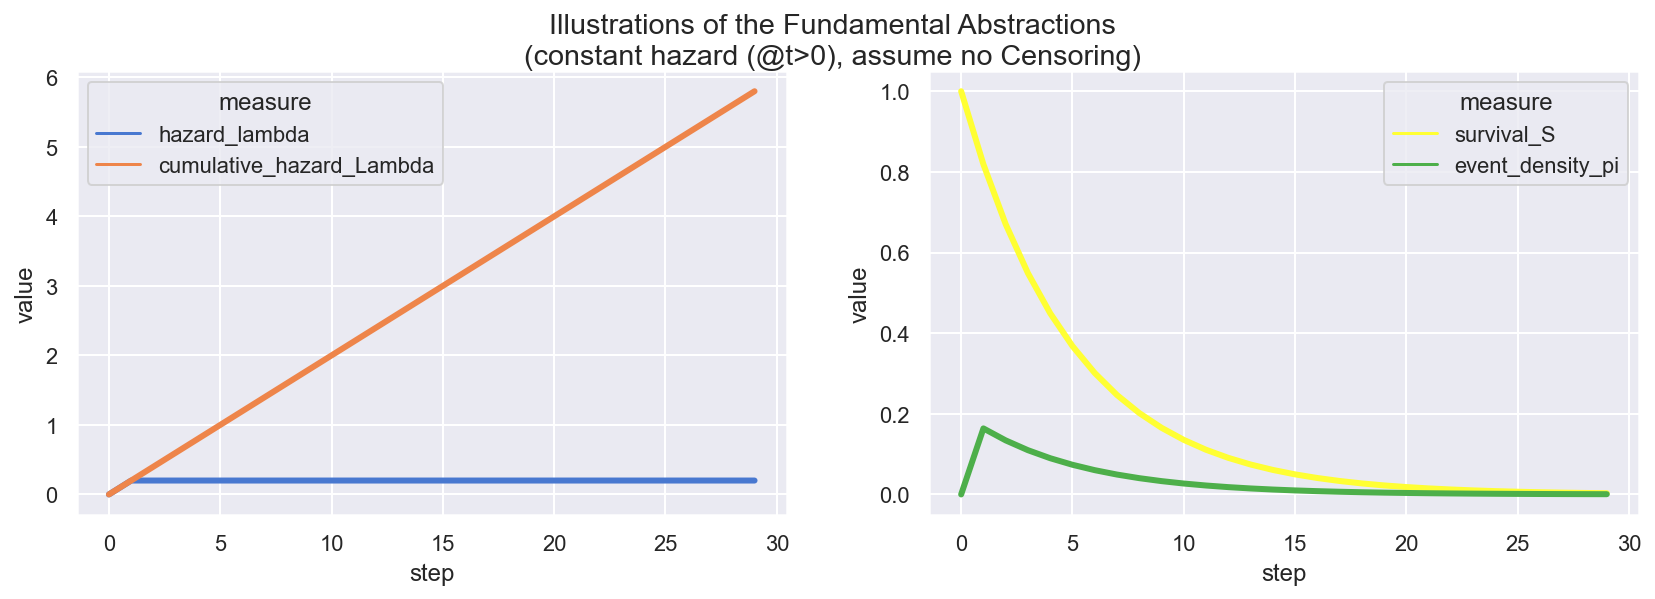

In [22]:
steps = 30
lam = np.concatenate((np.zeros(1), np.ones(steps - 1) * 0.2))
dfi = pd.DataFrame({'hazard_lambda': lam}, index=np.arange(steps))
dfi.index.name = 'step'
dfi['cumulative_hazard_Lambda'] = dfi['hazard_lambda'].cumsum()
dfi['survival_S'] = np.exp(-dfi['cumulative_hazard_Lambda'])
dfi['event_density_pi'] = dfi[['hazard_lambda', 'survival_S']].prod(axis=1)
# eda.display_ht(dfi)
dfm0 = pd.melt(dfi[['hazard_lambda', 'cumulative_hazard_Lambda']].reset_index(),id_vars='step', var_name='measure')
dfm1 = pd.melt(dfi[['survival_S', 'event_density_pi']].reset_index(), id_vars='step', var_name='measure')
f, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=False)
kws = dict(x='step', y='value', hue='measure', lw=3)
ax0 = sns.lineplot(**kws, data=dfm0, ax=axs[0])
ax1 = sns.lineplot(**kws, data=dfm1, ax=axs[1], palette='Set1_r')
_ = f.suptitle('Illustrations of the Fundamental Abstractions\n(constant hazard (@t>0), assume no Censoring)')

### 2.2.2 Varying hazard $\lambda$ (here, randomised)

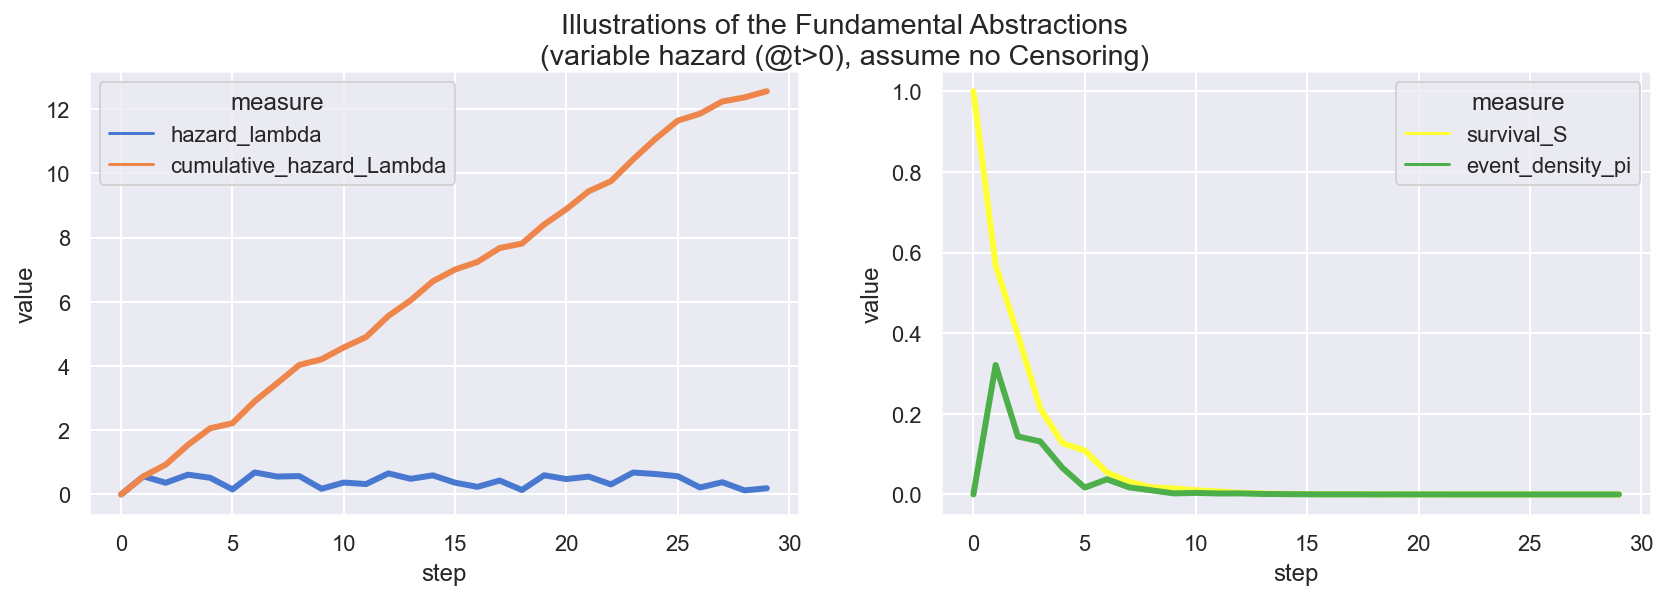

In [23]:
steps = 30
lam = lam = np.concatenate((np.zeros(1), RNG.uniform(low=0.1, high=0.7, size=steps - 1)))
dfi = pd.DataFrame({'hazard_lambda': lam}, index=np.arange(steps))
dfi.index.name = 'step'
dfi['cumulative_hazard_Lambda'] = dfi['hazard_lambda'].cumsum()
dfi['survival_S'] = np.exp(-dfi['cumulative_hazard_Lambda'])
dfi['event_density_pi'] = dfi[['hazard_lambda', 'survival_S']].prod(axis=1)
# eda.display_ht(dfi)
dfm0 = pd.melt(dfi[['hazard_lambda', 'cumulative_hazard_Lambda']].reset_index(), id_vars='step', var_name='measure')
dfm1 = pd.melt(dfi[['survival_S', 'event_density_pi']].reset_index(), id_vars='step', var_name='measure')
f, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=False)
kws = dict(x='step', y='value', hue='measure', lw=3)
ax0 = sns.lineplot(**kws, data=dfm0, ax=axs[0])
ax1 = sns.lineplot(**kws, data=dfm1, ax=axs[1], palette='Set1_r')
_ = f.suptitle('Illustrations of the Fundamental Abstractions\n(variable hazard (@t>0), assume no Censoring)')

## 2.3 Estimating $\log \mathcal{L}\pi(t)$ vs actual observed data (durations)

How shall we evidence a survival model against actual observations? We choose to minimise the log-likelihood of the event density function $\pi(t)$ vs the actual observed `duration` aka time-to-event:

$$
\begin{aligned}
\pi(t) &= \lambda(t) \cdot S(t)  \\
&= \lambda(t) \cdot \exp\big(-\Lambda(t)\big)  \\
\text{... so:}  \\
\log \mathcal{L}\ \pi(t) &= \sum_{i} \log \lambda(t)_{i} - \Lambda(t)_{i} \\
\end{aligned}
$$

This is a general form, and still doesn't affect the actual non/semi/parameteric form of the hazard function.

## 2.4 Incorporating Censoring

Pragmatically, we can only observe a group of individuals for a study period, so
it's possible for individuals to not experience the event of interest. In that
case all we know is that their contribution to the estimate of event density
$\pi$ is their survival function:

$$
\begin{aligned}
\mathcal{L}\ \pi(t)_{i} = S(t)_{i}
\end{aligned}
$$

Referring to 2.1.2 and 2.3 above, we see it's possible to incorporate the event
(e.g. death) and the non-event into the same relationship by just using an
indicator value $d_{i} \in \{0, 1\}$ which operates on time step $t$. 
Recall this is a general relationship, independent of the non/semi/parametric
form of $\lambda$

$$
\begin{aligned}
\mathcal{L} &= \prod_{i} \mathcal{L}_{i} \\
&= \prod_{i}\pi(t)_{i} \\
&= \prod_{i}\lambda(t)_{i}^{d_{i}}S(t)_{i} \\
&= \prod_{i}\lambda(t)_{i}^{d_{i}} \ \exp\big(-\Lambda(t)_{i}\big)  \\
\text{... so:} \\
\log \mathcal{L}(\pi(t)) &= \sum_{i} d_{i} \log \lambda(t)_{i} - \Lambda(t)_{i} \\
\end{aligned}
$$

> See **WWS507 Section 7.2.2 The Likelihood Function for Censored Data** for 
> details and derivations, and Betancourt's article for a thorough set of worked
> examples w.r.t. interval censoring

### 2.4.1 Illustration of kinds of Censoring

The following illustration is for policy lapses, but has the same behaviour for whatever the subject. 
Items under observation have a start event and and end event.

Particularly relevant for our work in NB300, NB301 on the UK ONS deaths-only dataset are the concepts of
**left-censoring** and **right-truncation**

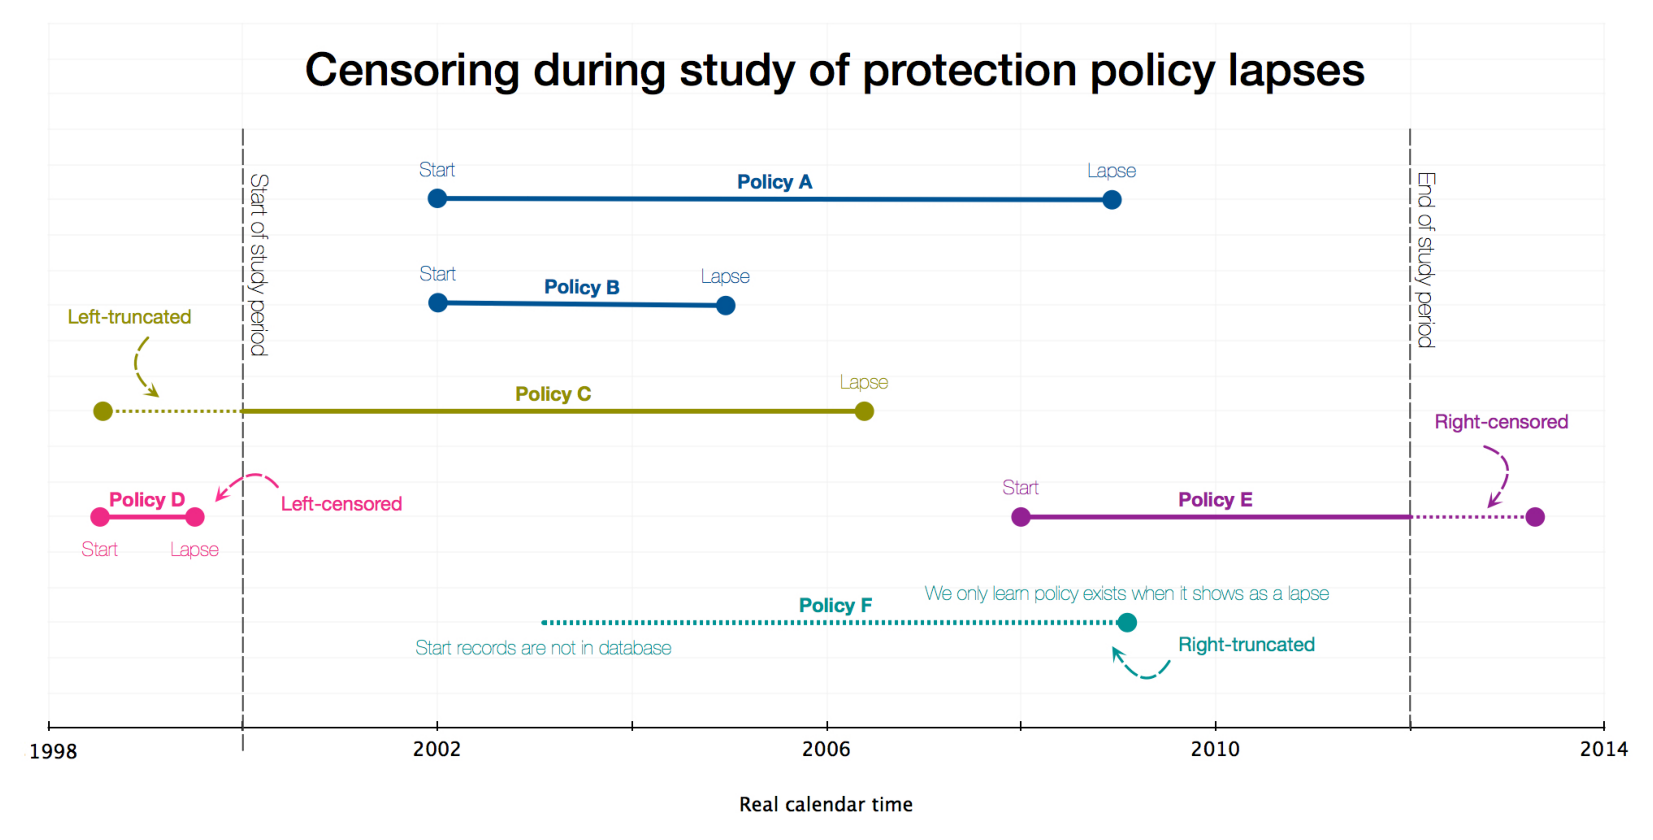

In [24]:
f = staticimgio.read(fn='censoring', extension='.jpeg', figsize=(16, 6))

---

---

# Notes

In [25]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:48:14

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.9.2
pyprojroot : 0.3.0
sys        : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
lifelines  : 0.30.0
scipy      : 1.14.1
seaborn    : 0.12.2
oreum_core : 0.9.7
pandas     : 2.2.3
statsmodels: 0.14.4
numpy      : 1.26.4



---
**Oreum OÜ &copy; 2024**